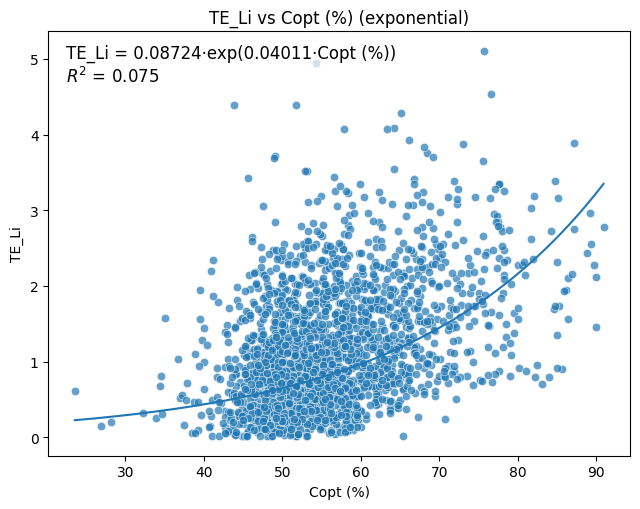

In [27]:
import os
os.chdir("/projects/cai-test")

csv_path = "TE_with_cds_backfill_clean_with_metrics.csv"  # change if needed
x_col    = "Copt (%)"
y_col    = "TE_Li"
fit      = "exponential"             # "linear" or "exponential"
drop_zeros_x = False                 # set True to drop rows with x == 0
drop_zeros_y = True                  # set True to drop rows with y == 0 (recommended for exponential)

# ---------------- Load & filter ----------------
df = pd.read_csv(csv_path)
data = df[[x_col, y_col]].copy()

# drop NaNs
data = data.dropna()

# optional: drop zeros
if drop_zeros_x:
    data = data[data[x_col] != 0]
if drop_zeros_y:
    data = data[data[y_col] != 0]

# guardrails
if fit == "exponential":
    # exponential requires positive y
    data = data[data[y_col] > 0]

if data.shape[0] < 2:
    raise ValueError("Not enough valid rows after filtering to fit the model.")

X = data[[x_col]].values.reshape(-1, 1)
y = data[y_col].values

# ---------------- Fit & predict ----------------
if fit == "linear":
    model = LinearRegression().fit(X, y)
    slope = float(model.coef_[0])
    intercept = float(model.intercept_)
    r2 = float(model.score(X, y))

    # prediction grid
    x_grid = np.linspace(data[x_col].min(), data[x_col].max(), 200).reshape(-1, 1)
    y_hat = model.predict(x_grid)

    eq_text = f"{y_col} = {slope:.4g}·{x_col} + {intercept:.4g}\n$R^2$ = {r2:.3f}"

elif fit == "exponential":
    # log-transform y: log(y) = log(a) + b*x
    log_y = np.log(y)
    model = LinearRegression().fit(X, log_y)
    b = float(model.coef_[0])
    log_a = float(model.intercept_)
    a = float(np.exp(log_a))

    # predictions in original space
    x_grid = np.linspace(data[x_col].min(), data[x_col].max(), 200).reshape(-1, 1)
    y_hat = a * np.exp(b * x_grid)

    # R^2 computed in original y-space
    y_fit = a * np.exp(b * X.flatten())
    ss_res = float(np.sum((y - y_fit)**2))
    ss_tot = float(np.sum((y - np.mean(y))**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    eq_text = f"{y_col} = {a:.4g}·exp({b:.4g}·{x_col})\n$R^2$ = {r2:.3f}"

else:
    raise ValueError("fit must be 'linear' or 'exponential'")

# ---------------- Plot ----------------
plt.figure(figsize=(6.5, 5.2))
sns.scatterplot(data=data, x=x_col, y=y_col, alpha=0.7)

plt.plot(x_grid, y_hat, lw=1.5)

# annotate in the upper-left corner
plt.text(0.03, 0.97, eq_text, transform=plt.gca().transAxes,
         ha="left", va="top", fontsize=12,
         bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

plt.title(f"{y_col} vs {x_col} ({fit})")
plt.tight_layout()
plt.show()